### Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.hybrid.physics_informed import PhysicsInformedHybridModel
import json

In [4]:
connection = Connection()
# Get client
client = connection.get_client()

In [5]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [6]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [7]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
W06 Record count before target preprocessing: 100
W06 Record count after target preprocessing: 100
W06 Record count after preprocessing: 100
W08 original record count: 69
W08 Record count before target preprocessing: 66
W08 Record count after target preprocessing: 66
W08 Record count after preprocessing: 66
W10 original record count: 222
W10 Record count before target preprocessing: 221
W10 Record count after target preprocessing: 221
W10 Record count after preprocessing: 221
W11 original record count: 154
W11 Record count before target preprocessing: 119
W11 Record count after target preprocessing: 119
W11 Record count after preprocessing: 119
W15 original record count: 86
W15 Record count before target preprocessing: 86
W15 Record count after target preprocessing: 86
W15 Record count after preprocessing: 86
W18 original record count: 89
W18 Record count before target preprocessing: 86
W18 Record count after target preproc

755

In [8]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          30
qg_mpfm          30
qw_mpfm          30
wc_mpfm           0
gor_mpfm         35
wgr_mpfm         36
gor_well_test     0
wgr_well_test     0
well_id           0
time_idx          0
dtype: int64

In [9]:
df_train, df_val, df_test = get_random_train_val_test_split_per_well_temporal_order(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=512, Validation=88, Test=155


In [10]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [11]:
def assert_model(hybrid_model):
    assert hasattr(hybrid_model, "_ml_feature_columns")
    assert len(hybrid_model._ml_feature_columns) > 0

    # Feature consistency check
    df_test_lag = hybrid_model._create_lagged_features(df_test).dropna()
    phys_test = hybrid_model.predict_physics(df_test_lag)

    # Feature consistency check
    X_test_df = hybrid_model._build_ml_features(df_test_lag, phys_test)
    assert list(X_test_df[hybrid_model._ml_feature_columns].columns) == hybrid_model._ml_feature_columns

In [12]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model.fit(df=df_train, df_val=df_val)
assert_model(model)

In [13]:
physics_scores = model.score_physics(df_test)
physics_scores

{'W06': {'qo': {'r2': 0.5421442217663115,
   'mae': 16.942390228378574,
   'rmse': 20.965721430908285,
   'mape (%)': 15.907325067145173,
   'mpe (%)': -1.4040829930965026},
  'qw': {'r2': -0.36270014109899784,
   'mae': 1.036426082613359,
   'rmse': 1.1935335513902412,
   'mape (%)': 137.94516783141572,
   'mpe (%)': 72.92725257759012},
  'qg': {'r2': 0.4913343561932917,
   'mae': 2344.1020207595907,
   'rmse': 2688.454352342288,
   'mape (%)': 15.957182910949507,
   'mpe (%)': -15.570344876044997},
  'wgr': {'r2': -0.3548984002028779,
   'mae': 6.966184225803e-05,
   'rmse': 8.585809715050797e-05,
   'mape (%)': 72.61026553016382,
   'mpe (%)': 19.573166459898697},
  'gor': {'r2': -183.89710681494114,
   'mae': 20.38705115895929,
   'rmse': 28.851520041622816,
   'mape (%)': 16.35057897186874,
   'mpe (%)': -10.544850402423913}},
 'W08': {'qo': {'r2': -0.28776448752654815,
   'mae': 10.190237187698095,
   'rmse': 15.407924948818229,
   'mape (%)': 35.624772850488824,
   'mpe (%)': -4

In [14]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.831332090913696,
   'mae': 9.344228265161062,
   'rmse': 12.725114299492693,
   'mape (%)': 8.313601492603505,
   'mpe (%)': 0.19467378754972556},
  'qw': {'r2': -3.527312443077345,
   'mae': 1.9202441323233548,
   'rmse': 2.175478097630499,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.924867817851172,
   'mae': 810.0713485813609,
   'rmse': 1033.2358478452627,
   'mape (%)': 7.466421096047308,
   'mpe (%)': -1.6319264718345345},
  'wgr': {'r2': -3.5982817588775164,
   'mae': 0.00013991860860139841,
   'rmse': 0.00015817057143736621,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -80.14458458635019,
   'mae': 12.448942034099128,
   'rmse': 19.113200328329196,
   'mape (%)': 9.975567173877092,
   'mpe (%)': -1.166158172797639}},
 'W08': {'qo': {'r2': 0.13601220432541328,
   'mae': 7.877902817334967,
   'rmse': 12.620592262279068,
   'mape (%)': 25.101790721819796,
   'mpe (%)': -13.914244149856245},
  'qw': {'r2': 0.3395712871845329

In [15]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9622127297511719,
   'mae': 5.108947375686423,
   'rmse': 6.02307430775345,
   'mape (%)': 3.8413872916784455,
   'mpe (%)': 3.7315809220772405},
  'qw': {'r2': -2.551445211608438,
   'mae': 1.6981038914964743,
   'rmse': 1.9268017899703545,
   'mape (%)': 89.03548057348473,
   'mpe (%)': -89.03548057348473},
  'qg': {'r2': 0.987376355312584,
   'mae': 399.2362987340147,
   'rmse': 423.52479917303805,
   'mape (%)': 2.6046409019487435,
   'mpe (%)': 2.6046409019487435},
  'wgr': {'r2': -2.1170988057111826,
   'mae': 0.00011993686498377755,
   'rmse': 0.00013022764245540662,
   'mape (%)': 88.504528548937,
   'mpe (%)': -88.504528548937},
  'gor': {'r2': -0.9333627493630794,
   'mae': 2.19215720825003,
   'rmse': 2.9502601585677786,
   'mape (%)': 1.7605653849552112,
   'mpe (%)': -1.0449350954200944}},
 'W08': {'qo': {'r2': 0.8458880146604326,
   'mae': 4.429595447862673,
   'rmse': 5.3302077912178145,
   'mape (%)': 17.59618938248461,
   'mpe (%)': -8.881713363

In [16]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

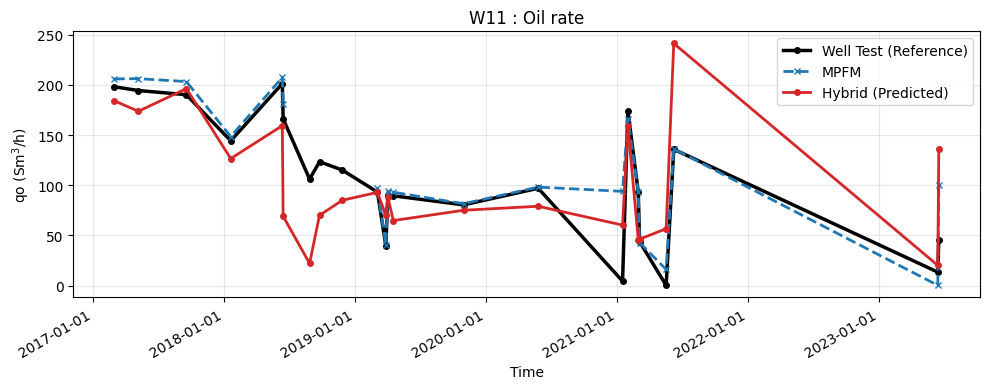

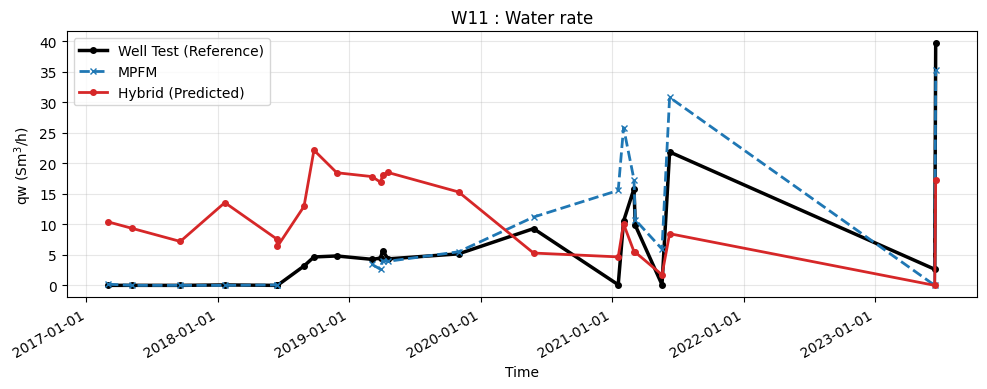

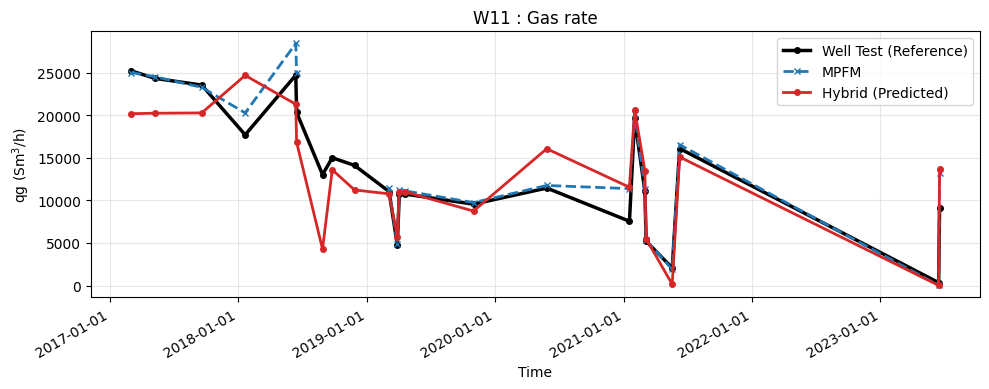

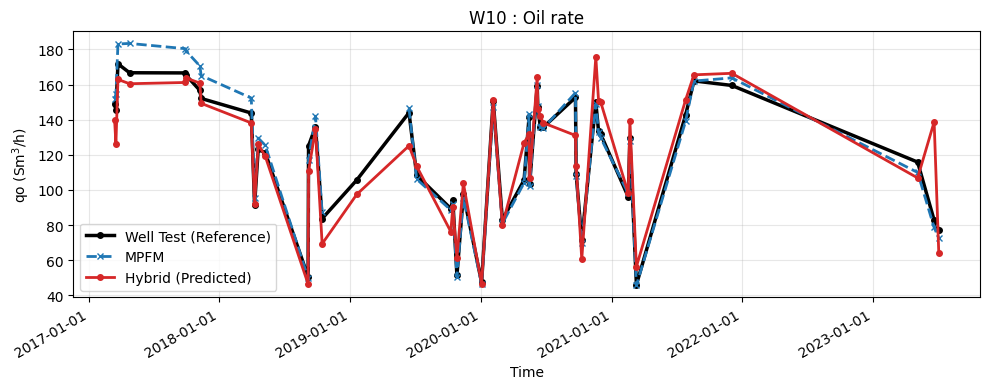

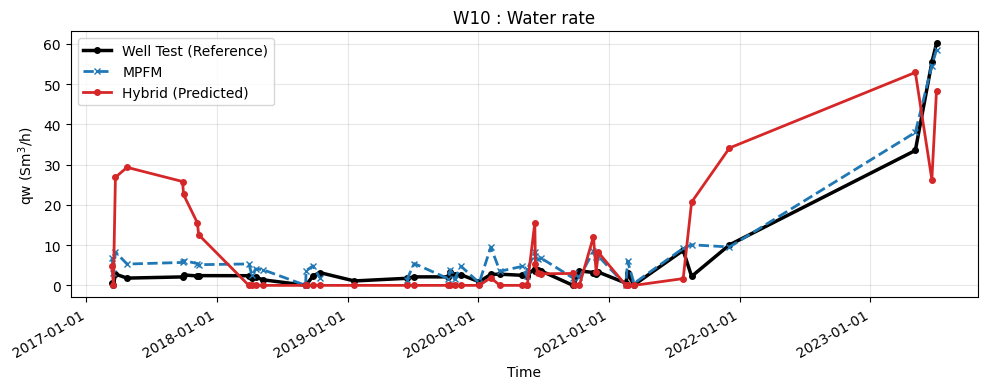

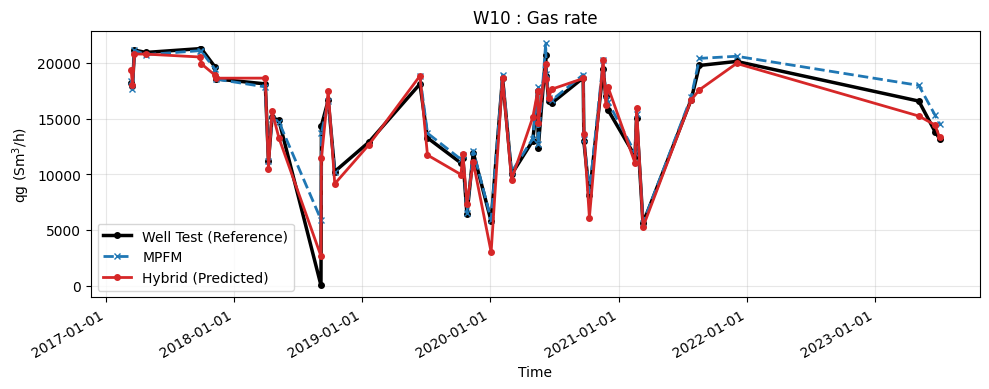

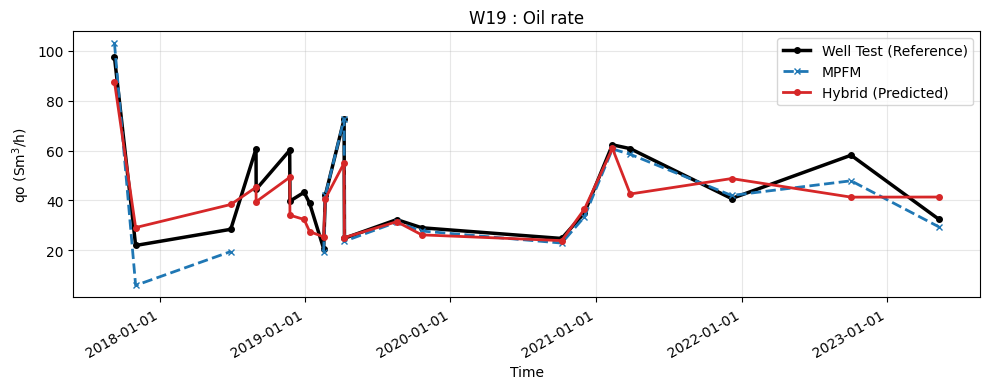

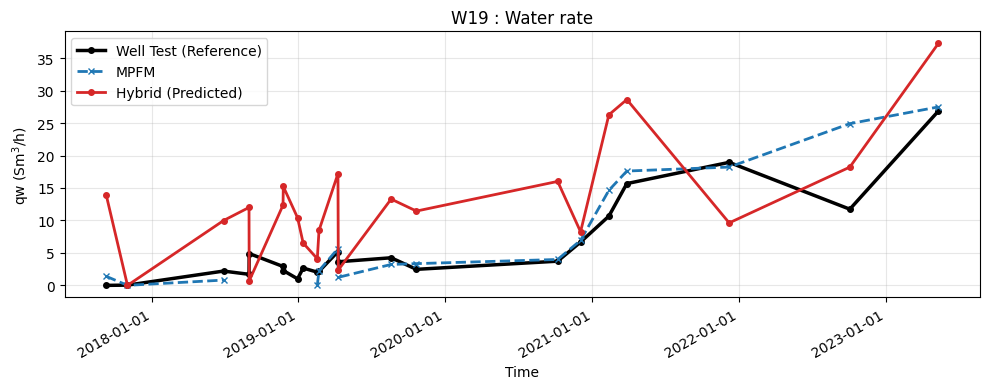

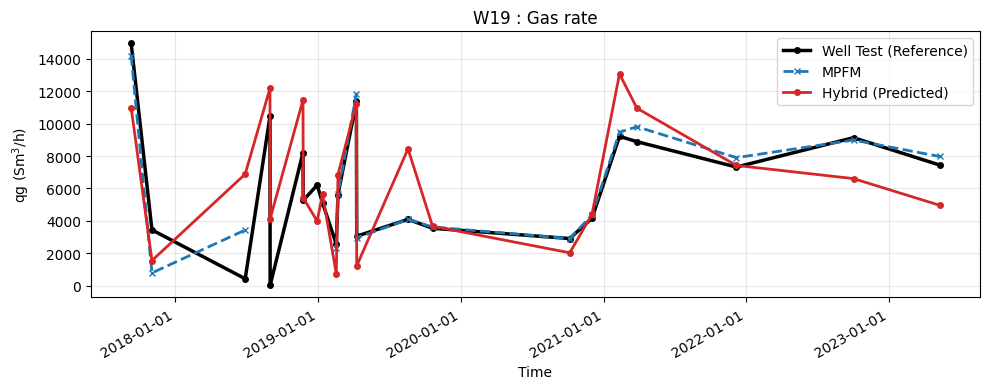

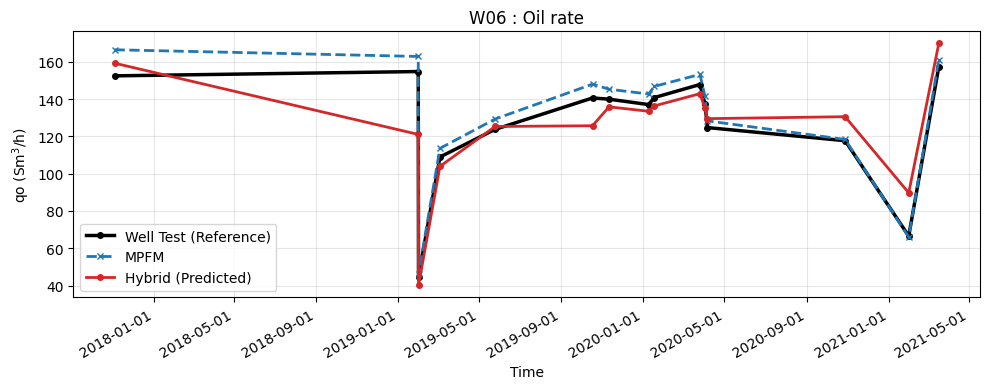

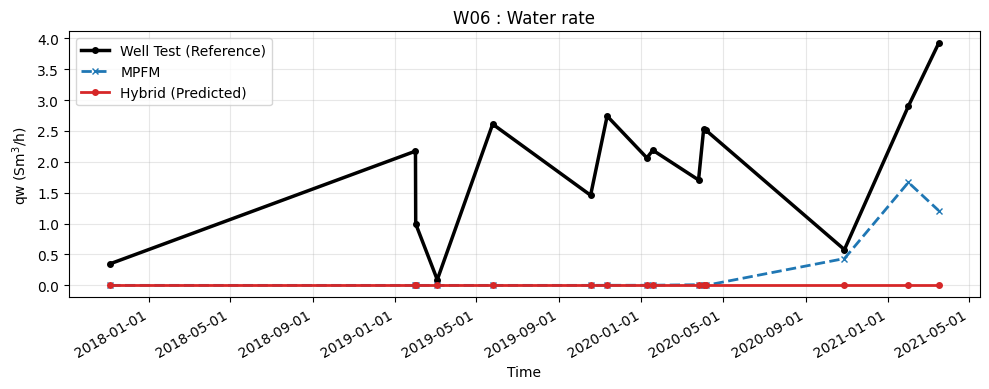

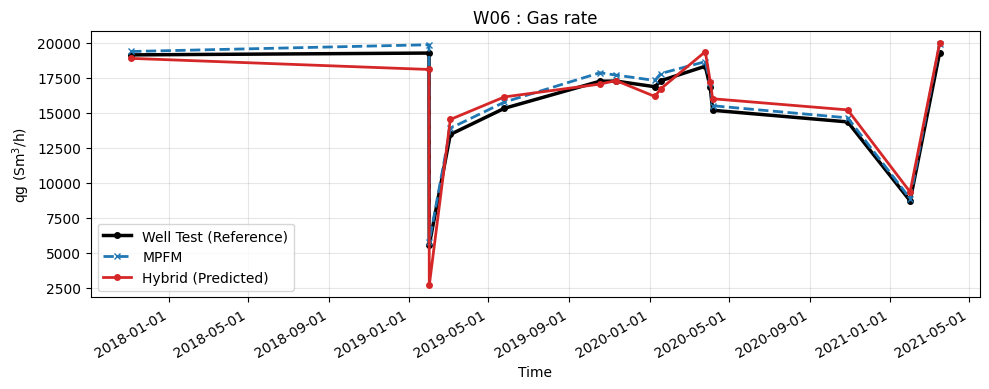

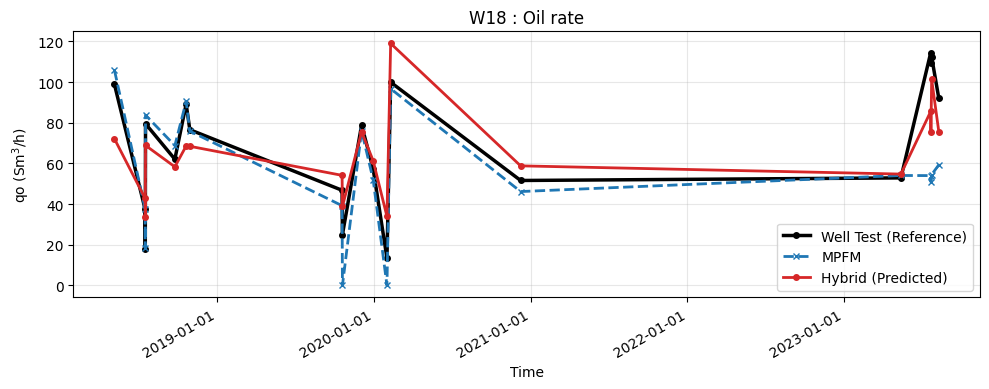

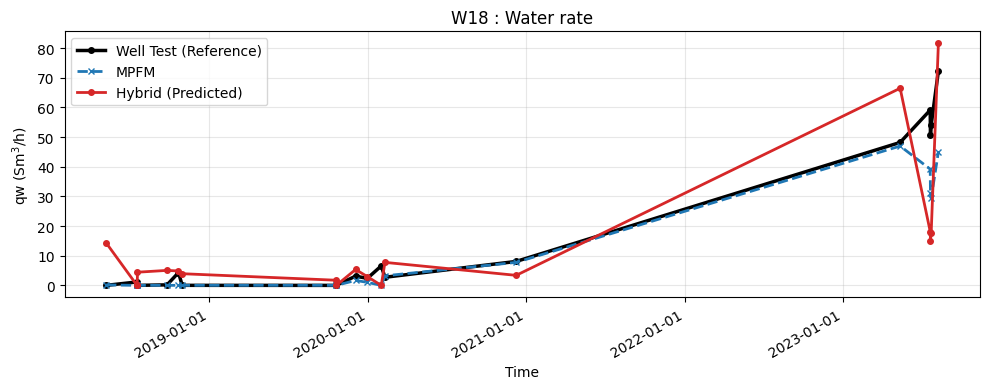

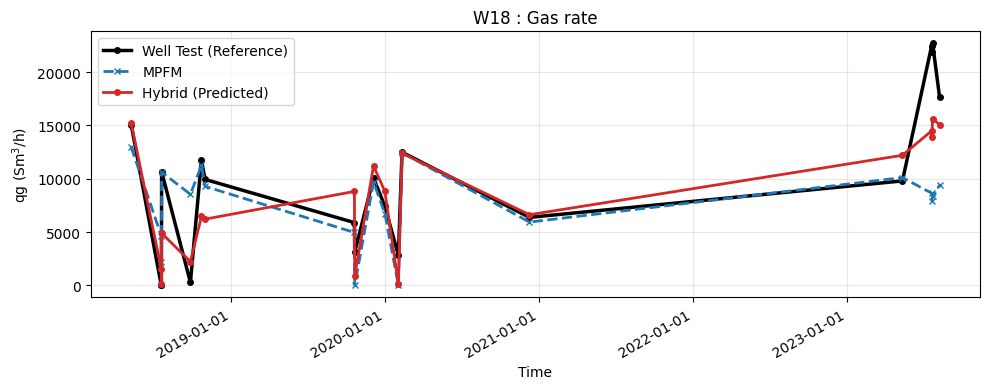

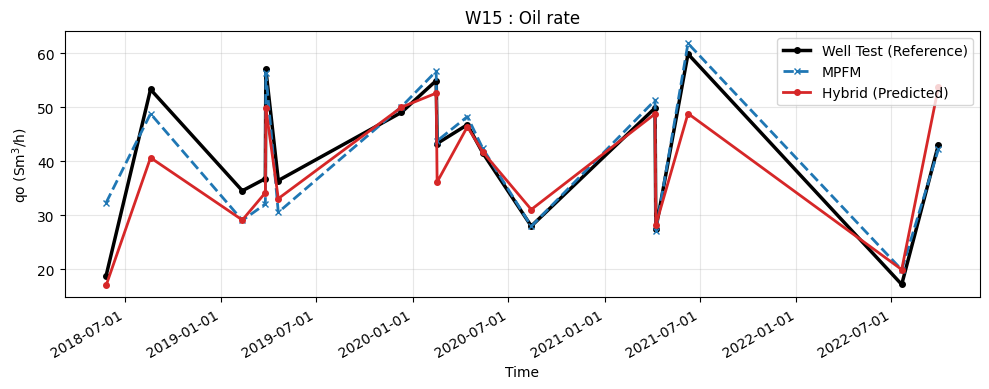

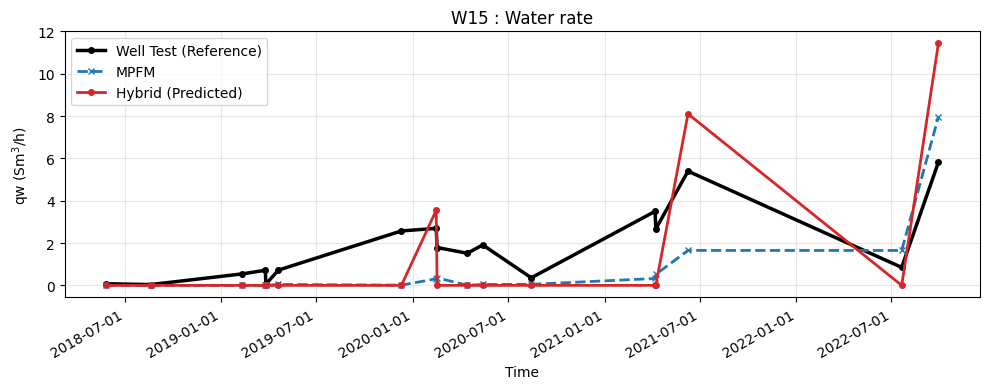

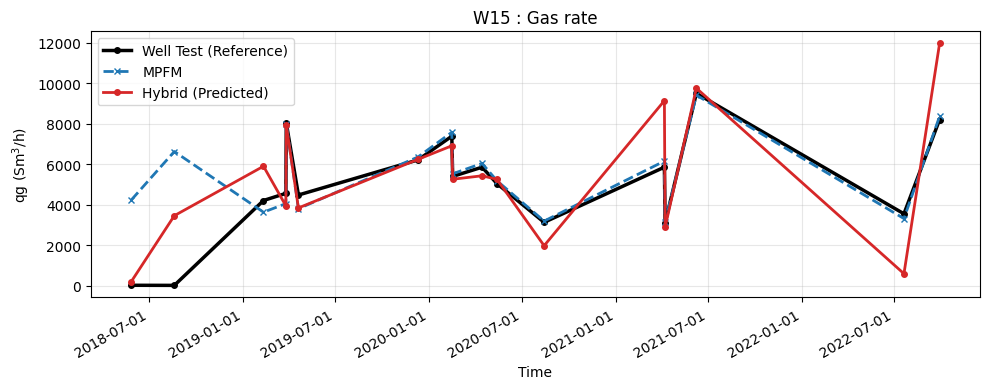

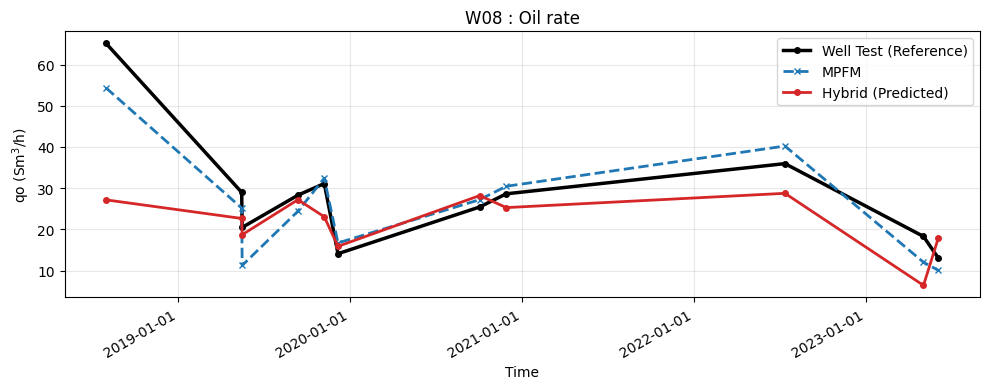

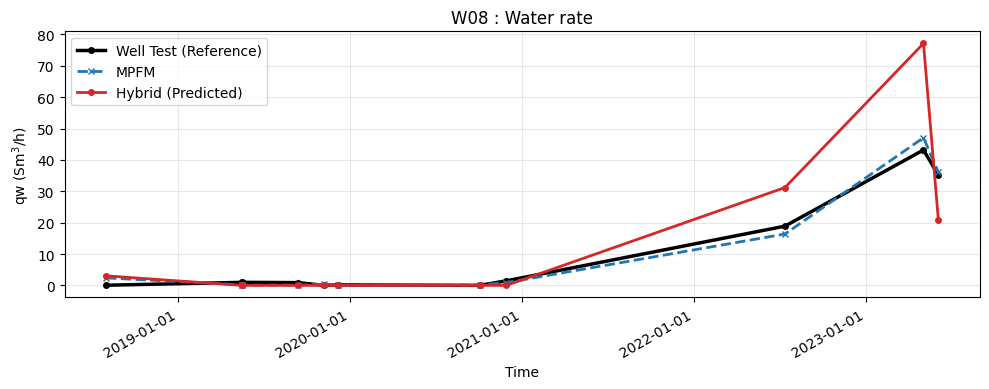

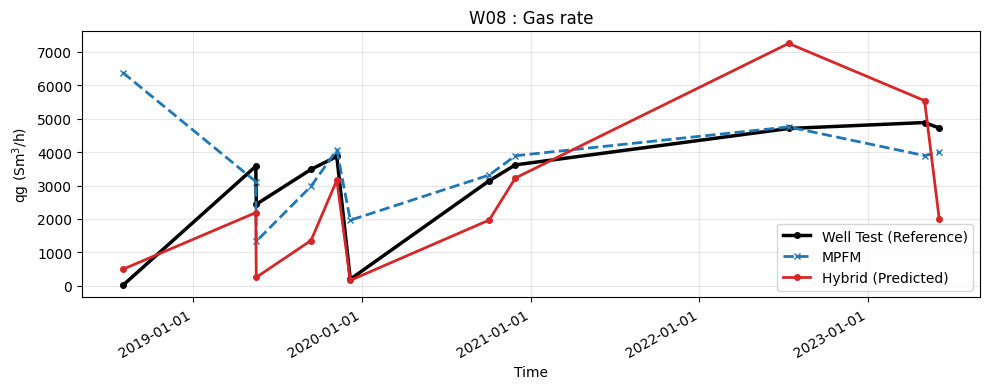

In [17]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [18]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
print(f"Train={len(df_train_lowo)}, Val={len(df_val_lowo)}, Calibration={len(df_calibration_lowo)}, Test={len(df_test_lowo)}")

Train=433, Val=101, Calibration=22, Test=199


In [19]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)



In [20]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)

In [21]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.5133095603798665,
   'mae': 16.83552819490374,
   'rmse': 22.323046659895617,
   'mape (%)': 16.611835157969352,
   'mpe (%)': 1.5966517214377984},
  'qw': {'r2': 0.5618021150965247,
   'mae': 3.3725516731912037,
   'rmse': 6.390664322408403,
   'mape (%)': 27683.716644731387,
   'mpe (%)': 27610.93193821687},
  'qg': {'r2': 0.4973948138373433,
   'mae': 2190.520022243276,
   'rmse': 2892.509869067653,
   'mape (%)': 237.414543321432,
   'mpe (%)': 215.42924264727526},
  'wgr': {'r2': 0.41828240185054,
   'mae': 0.0003057091824340181,
   'rmse': 0.0006589256904129563,
   'mape (%)': 140.38163876989722,
   'mpe (%)': 67.76428580020544},
  'gor': {'r2': -0.9963776294645299,
   'mae': 14.021745162685008,
   'rmse': 21.941190769512065,
   'mape (%)': 164.42466832470723,
   'mpe (%)': 147.3196725494666}}}

In [22]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.7610103414580706,
   'mae': 11.259728626822426,
   'rmse': 15.642876400106262,
   'mape (%)': 10.487287074007712,
   'mpe (%)': 1.7904516921837994},
  'qw': {'r2': -3.0155163309616055,
   'mae': 7.5184602394744715,
   'rmse': 19.34557159068786,
   'mape (%)': 213.21856626951688,
   'mpe (%)': 34.67443178631624},
  'qg': {'r2': 0.7749781728940222,
   'mae': 1548.205271469617,
   'rmse': 1935.4131610227737,
   'mape (%)': 75.76653545070018,
   'mpe (%)': 54.582012078345},
  'wgr': {'r2': -1.2150007182085139,
   'mae': 0.0005098286719980848,
   'rmse': 0.0012857818021433922,
   'mape (%)': 226.94008496087363,
   'mpe (%)': 49.459103319724385},
  'gor': {'r2': -3.8625446699105623,
   'mae': 21.111551102230035,
   'rmse': 34.242908715981535,
   'mape (%)': 80.13375671478029,
   'mpe (%)': 56.07505419697323}}}

In [23]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9578632311509047,
   'mae': 3.899350727610121,
   'rmse': 6.5779293774238585,
   'mape (%)': 3.2529852250235844,
   'mpe (%)': 1.0987521994310645},
  'qw': {'r2': 0.9082859051517885,
   'mae': 2.504800672381479,
   'rmse': 2.937882886903735,
   'mape (%)': 88436.74602976633,
   'mpe (%)': 88423.89258758005},
  'qg': {'r2': 0.9368275363460621,
   'mae': 520.4029522721138,
   'rmse': 1027.2454387262098,
   'mape (%)': 437.3072103442719,
   'mpe (%)': 436.4665503942578},
  'wgr': {'r2': 0.9396050141883865,
   'mae': 0.00017061834079783002,
   'rmse': 0.00021342137820723193,
   'mape (%)': 97.6339436125996,
   'mpe (%)': 85.26314844994054},
  'gor': {'r2': 0.10791366148986992,
   'mae': 7.722941840670556,
   'rmse': 14.741226610779103,
   'mape (%)': 444.61906240214705,
   'mpe (%)': 440.8706278965924}}}

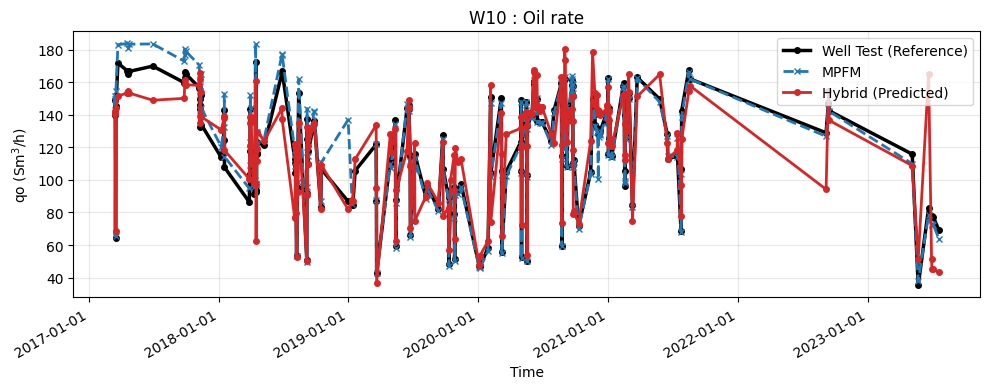

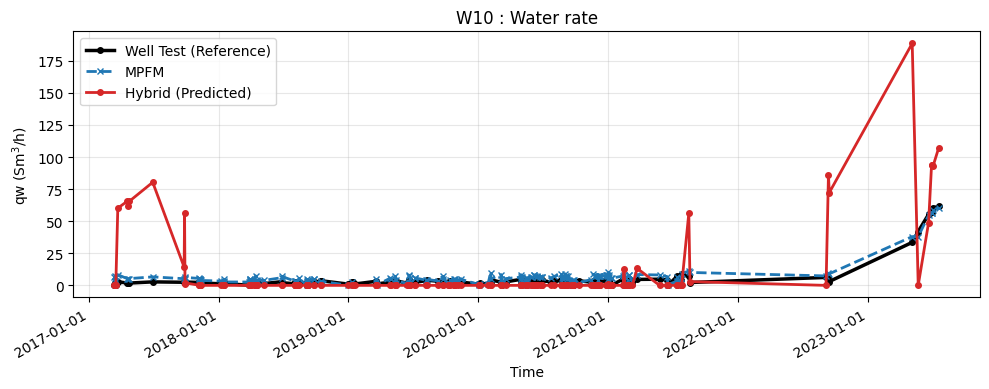

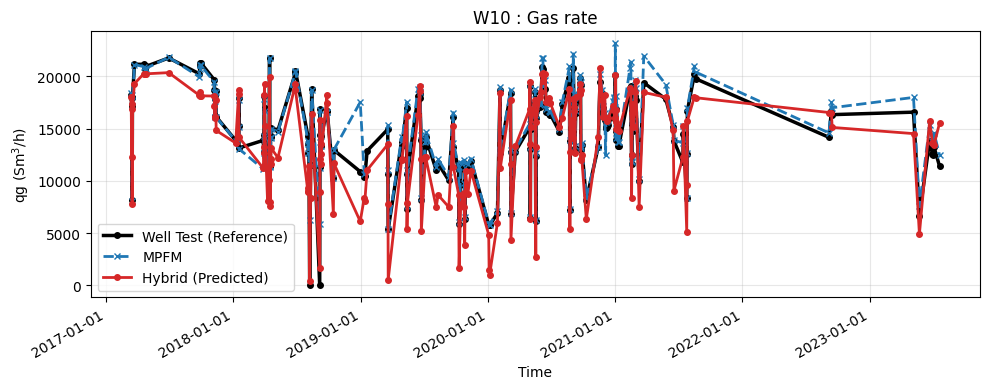

In [24]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [25]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [26]:
# df_resampled.index

In [27]:
# df_resampled.columns

In [28]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [29]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [30]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [31]:
# summarize_null(df_generated)